In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import torch
import librosa
import numpy as np
import torchaudio.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import librosa.display
from torch.nn.utils.rnn import pad_sequence
from tqdm.notebook import tqdm


import warnings
warnings.filterwarnings('ignore')



In [2]:
def load_protocol(protocol_path):
    data = []
    with open(protocol_path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            parts = line.strip().split()
            filename = parts[1]  # Audio filename
            label = 1 if parts[-1] == "bonafide" else 0  # Convert to binary label (1=real, 0=fake)
            data.append((filename, label))
    return data

In [3]:
class SpoofDataset(Dataset):
    def __init__(self, dataset_path, protocol_path, max_len=100):
        self.dataset_path = dataset_path
        self.data = load_protocol(protocol_path)
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        filename, label = self.data[idx]
        file_path = os.path.join(self.dataset_path, filename + ".flac")

        y, sr = librosa.load(file_path, sr=16000)
        y, _ = librosa.effects.trim(y)

        def normalize_and_pad(x):
            if x.shape[1] < self.max_len:
                pad_width = self.max_len - x.shape[1]
                x = np.pad(x, ((0, 0), (0, pad_width)), mode='constant')
            else:
                x = x[:, :self.max_len]
            return x

        mfcc = normalize_and_pad(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20))
        mel = normalize_and_pad(librosa.power_to_db(librosa.feature.melspectrogram(y=y, sr=sr, n_mels=20), ref=np.max))
        cqt = normalize_and_pad(librosa.amplitude_to_db(np.abs(librosa.cqt(y=y, sr=sr, n_bins=20)), ref=np.max))
        cqcc = normalize_and_pad(np.zeros_like(mfcc))  # Placeholder

        # Add channel dimension: (1, 20, 100)
        mfcc = torch.tensor(mfcc, dtype=torch.float32).unsqueeze(0)
        mel = torch.tensor(mel, dtype=torch.float32).unsqueeze(0)
        cqt = torch.tensor(cqt, dtype=torch.float32).unsqueeze(0)
        cqcc = torch.tensor(cqcc, dtype=torch.float32).unsqueeze(0)

        return (mfcc, mel, cqt, cqcc), torch.tensor(label, dtype=torch.float32)


In [4]:
train_dataset = SpoofDataset(
    dataset_path="../LA/ASVspoof2019_LA_train/flac/",
    protocol_path="../LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt",
    max_len=100  # Adjust this based on dataset
)

eval_dataset = SpoofDataset(
    dataset_path="../LA/ASVspoof2019_LA_eval/flac/",
    protocol_path="../LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt",
    max_len=100  # Adjust this based on dataset
)
dev_dataset = SpoofDataset(
    dataset_path="../LA/ASVspoof2019_LA_dev/flac/",
    protocol_path="../LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.dev.trl.txt",
    max_len=100  # Adjust this based on dataset
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

eval_loader = DataLoader(eval_dataset, batch_size=32, shuffle=False)

dev_loader = DataLoader(dev_dataset,batch_size=32,shuffle=False)

In [5]:
sample_mfcc, sample_label = train_dataset[0]
features, *_ = sample_mfcc  # unpack only the first element (MFCC features)
print(f"MFCC Shape: {features.shape}, Label: {sample_label}")


MFCC Shape: torch.Size([1, 20, 100]), Label: 1.0


In [6]:


class FeatureCNN(nn.Module):
    def __init__(self, in_channels=1):
        super(FeatureCNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

    def forward(self, x):
        return self.cnn(x)

class MultiFeatureCNN_BiLSTM(nn.Module):
    def __init__(self):
        super(MultiFeatureCNN_BiLSTM, self).__init__()

        # 4 parallel CNNs for MFCC, Mel, CQCC, CQT
        self.cnn_mfcc = FeatureCNN()
        self.cnn_mel = FeatureCNN()
        self.cnn_cqcc = FeatureCNN()
        self.cnn_cqt = FeatureCNN()

        # Assuming input shape: (batch, 1, 20, 100) for each feature
        # After 3 layers of MaxPool2d(2), time/freq reduce by 2^3 = 8
        # e.g., (20, 100) -> (2, 12), with 128 channels
        self.lstm_input_size = 1024  # channels * freq (height)
        self.lstm = nn.LSTM(input_size=self.lstm_input_size, hidden_size=64,
                            num_layers=2, batch_first=True, bidirectional=True)

        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(64 * 2, 1)  # BiLSTM output

    def forward(self, mfcc, mel, cqcc, cqt):
        # Each input: (batch, 1, 20, 100)
        mfcc_out = self.cnn_mfcc(mfcc)
        mel_out = self.cnn_mel(mel)
        cqcc_out = self.cnn_cqcc(cqcc)
        cqt_out = self.cnn_cqt(cqt)

        # All outputs: (batch, 128, 2, 12) → reshape for LSTM
        def reshape_for_lstm(x):
            x = x.permute(0, 3, 1, 2)  # (batch, time=12, channels, freq=2)
            return x.reshape(x.size(0), x.size(1), -1)  # (batch, time, features)

        mfcc_seq = reshape_for_lstm(mfcc_out)
        mel_seq = reshape_for_lstm(mel_out)
        cqcc_seq = reshape_for_lstm(cqcc_out)
        cqt_seq = reshape_for_lstm(cqt_out)

        # Concatenate along feature axis
        combined_seq = torch.cat([mfcc_seq, mel_seq, cqcc_seq, cqt_seq], dim=2)  # (batch, time, features * 4)

        lstm_out, _ = self.lstm(combined_seq)
        lstm_out = self.dropout(lstm_out)

        out = self.fc(lstm_out[:, -1, :])
        return out


In [7]:
def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for (mfcc, mel, cqt, cqcc), labels in val_loader:
            mfcc, mel, cqt, cqcc, labels = mfcc.to(device), mel.to(device), cqt.to(device), cqcc.to(device), labels.to(device)

            outputs = model(mfcc, mel, cqt, cqcc).squeeze(1)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            # Correctly calculate predictions using sigmoid with BCEWithLogitsLoss
            predictions = (torch.sigmoid(outputs) >= 0.5).float()
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total * 100
    return total_loss / len(val_loader), val_acc

In [8]:
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.title("Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Val Accuracy')
    plt.title("Accuracy Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()

    plt.tight_layout()
    plt.show()


In [9]:
from tqdm import tqdm

def train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=10, save_path="best_model.pth"):
    best_val_loss = float('inf')

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0

        # Progress bar
        progress_bar = tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}")

        for (mfcc, mel, cqt, cqcc), labels in progress_bar:
            mfcc, mel, cqt, cqcc = mfcc.to(device), mel.to(device), cqt.to(device), cqcc.to(device)
            labels = labels.to(device).float()

            optimizer.zero_grad()
            outputs = model(mfcc, mel, cqt, cqcc).squeeze(1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            predictions = (outputs >= 0.5).float()
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

        train_loss = total_loss / len(train_loader)
        train_acc = correct / total * 100
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation step
        val_loss, val_acc = validate(model, dev_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        # Epoch result summary
        print(f"\nEpoch {epoch+1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

        # Always save best model based on val loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), save_path)
            print("✅ Saved best model!\n")

    # Final metric plotting
    plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MultiFeatureCNN_BiLSTM().to(device)

criterion = nn.BCEWithLogitsLoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.01)



In [11]:
def test(model, test_loader, criterion, device, model_path):
    """
    Function to test the model on the dev dataset.
    Loads the best saved model weights.
    """
    try:
        model.load_state_dict(torch.load(model_path))
    except FileNotFoundError:
        print(f"Error: Model file not found at {model_path}. Please ensure the model is trained and saved.")
        return

    model.eval()
    
    total_loss, correct, total = 0, 0, 0
    
    # Progress bar for testing
    progress_bar = tqdm(test_loader, desc="Testing", leave=True)

    with torch.no_grad():
        for (mfcc, mel, cqt, cqcc), labels in progress_bar:
            mfcc, mel, cqt, cqcc, labels = mfcc.to(device), mel.to(device), cqt.to(device), cqcc.to(device), labels.to(device)

            outputs = model(mfcc, mel, cqt, cqcc).squeeze(1)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            predictions = (torch.sigmoid(outputs) >= 0.5).float()
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
            
            # Update progress bar with live metrics
            current_accuracy = 100. * correct / total
            progress_bar.set_postfix(loss=f"{loss.item():.4f}", accuracy=f"{current_accuracy:.2f}%")

    test_acc = correct / total * 100
    avg_loss = total_loss / len(test_loader)
    
    print("\n--- Testing Results on dev_dataset ---")
    print(f"Test Loss: {avg_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.2f}%")



Epoch 1/20: 100%|██████████| 794/794 [10:47<00:00,  1.23it/s]



Epoch 1/20
Train Loss: 0.3343 | Val Loss: 0.3298 | Train Acc: 89.83% | Val Acc: 89.74%
✅ Saved best model!



Epoch 2/20: 100%|██████████| 794/794 [11:53<00:00,  1.11it/s]



Epoch 2/20
Train Loss: 0.3328 | Val Loss: 0.3319 | Train Acc: 89.83% | Val Acc: 89.74%


Epoch 3/20: 100%|██████████| 794/794 [16:15<00:00,  1.23s/it]



Epoch 3/20
Train Loss: 0.3328 | Val Loss: 0.3321 | Train Acc: 89.83% | Val Acc: 89.74%


Epoch 4/20: 100%|██████████| 794/794 [16:14<00:00,  1.23s/it]



Epoch 4/20
Train Loss: 0.3320 | Val Loss: 0.3376 | Train Acc: 89.83% | Val Acc: 89.74%


Epoch 5/20: 100%|██████████| 794/794 [15:40<00:00,  1.18s/it]



Epoch 5/20
Train Loss: 0.3304 | Val Loss: 0.3312 | Train Acc: 89.83% | Val Acc: 89.74%


Epoch 6/20: 100%|██████████| 794/794 [15:35<00:00,  1.18s/it]



Epoch 6/20
Train Loss: 0.3302 | Val Loss: 0.3305 | Train Acc: 89.83% | Val Acc: 89.74%


Epoch 7/20: 100%|██████████| 794/794 [15:39<00:00,  1.18s/it]



Epoch 7/20
Train Loss: 0.3301 | Val Loss: 0.3317 | Train Acc: 89.83% | Val Acc: 89.74%


Epoch 8/20: 100%|██████████| 794/794 [15:27<00:00,  1.17s/it]



Epoch 8/20
Train Loss: 0.3294 | Val Loss: 0.3306 | Train Acc: 89.83% | Val Acc: 89.74%


Epoch 9/20: 100%|██████████| 794/794 [15:44<00:00,  1.19s/it]



Epoch 9/20
Train Loss: 0.3291 | Val Loss: 0.3305 | Train Acc: 89.83% | Val Acc: 89.74%


Epoch 10/20: 100%|██████████| 794/794 [15:36<00:00,  1.18s/it]



Epoch 10/20
Train Loss: 0.3290 | Val Loss: 0.3310 | Train Acc: 89.83% | Val Acc: 89.74%


Epoch 11/20: 100%|██████████| 794/794 [15:31<00:00,  1.17s/it]



Epoch 11/20
Train Loss: 0.3291 | Val Loss: 0.3305 | Train Acc: 89.83% | Val Acc: 89.74%


Epoch 12/20: 100%|██████████| 794/794 [15:38<00:00,  1.18s/it]



Epoch 12/20
Train Loss: 0.3295 | Val Loss: 0.3305 | Train Acc: 89.83% | Val Acc: 89.74%


Epoch 13/20: 100%|██████████| 794/794 [15:40<00:00,  1.18s/it]



Epoch 13/20
Train Loss: 0.3291 | Val Loss: 0.3309 | Train Acc: 89.83% | Val Acc: 89.74%


Epoch 14/20: 100%|██████████| 794/794 [15:40<00:00,  1.18s/it]



Epoch 14/20
Train Loss: 0.3287 | Val Loss: 0.3310 | Train Acc: 89.83% | Val Acc: 89.74%


Epoch 15/20: 100%|██████████| 794/794 [15:34<00:00,  1.18s/it]



Epoch 15/20
Train Loss: 0.3289 | Val Loss: 0.3306 | Train Acc: 89.83% | Val Acc: 89.74%


Epoch 16/20: 100%|██████████| 794/794 [15:40<00:00,  1.18s/it]



Epoch 16/20
Train Loss: 0.3289 | Val Loss: 0.3311 | Train Acc: 89.83% | Val Acc: 89.74%


Epoch 17/20: 100%|██████████| 794/794 [15:40<00:00,  1.18s/it]



Epoch 17/20
Train Loss: 0.3292 | Val Loss: 0.3317 | Train Acc: 89.83% | Val Acc: 89.74%


Epoch 18/20: 100%|██████████| 794/794 [15:36<00:00,  1.18s/it]



Epoch 18/20
Train Loss: 0.3295 | Val Loss: 0.3319 | Train Acc: 89.83% | Val Acc: 89.74%


Epoch 19/20: 100%|██████████| 794/794 [15:41<00:00,  1.19s/it]



Epoch 19/20
Train Loss: 0.3291 | Val Loss: 0.3305 | Train Acc: 89.83% | Val Acc: 89.74%


Epoch 20/20: 100%|██████████| 794/794 [15:33<00:00,  1.18s/it]



Epoch 20/20
Train Loss: 0.3291 | Val Loss: 0.3305 | Train Acc: 89.83% | Val Acc: 89.74%


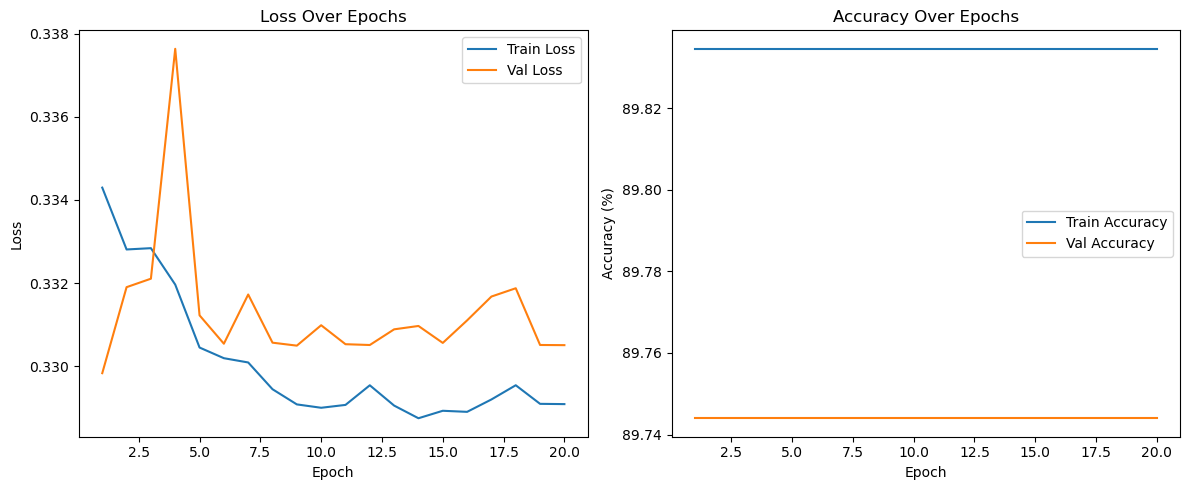

In [12]:
train(
    model,
    train_loader,      # must return ((mfcc, mel, cqcc, cqt), label)
    dev_loader,        # Using dev_loader for validation
    optimizer,
    criterion,
    device,
    epochs=20,
    save_path="best_cnn_bilstm_model.pth"
)

In [13]:

test_model = MultiFeatureCNN_BiLSTM().to(device)

test(test_model, eval_loader, criterion, device, "best_cnn_bilstm_model.pth")

Testing: 100%|██████████| 2227/2227 [25:19<00:00,  1.47it/s, accuracy=89.68%, loss=1.0877]


--- Testing Results on dev_dataset ---
Test Loss: 0.3287
Test Accuracy: 89.68%


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model2 = MultiFeatureCNN_BiLSTM().to(device)

criterion = nn.BCEWithLogitsLoss()  # Binary Cross Entropy Loss
optimizer2 = optim.Adam(model.parameters(), lr=0.1)

train(
    model2,
    train_loader,      # must return ((mfcc, mel, cqcc, cqt), label)
    dev_loader,        # Using dev_loader for validation
    optimizer2,
    criterion,
    device,
    epochs=20,
    save_path="best_cnn_bilstm_model2.pth"
)

In [14]:
##test_model = MultiFeatureCNN_BiLSTM().to(device)
#test_model.load_state_dict(torch.load("best_model.pth", map_location=device))
#test_model.eval()  # Set to evaluation mode
#test(test_model, eval_loader, criterion, device, "best_model.pth")